#  Прогнозирование заказов такси

### Описание проекта

Чтобы привлекать больше водителей такси в период пиковой нагрузки в аэропортах, необходимо спрогнозировать количество заказов на следующий час. Строится модель для такого предсказания.

### План проекта

    1. Загрузка и подготовка данных
    2. Исследовательский анализ данных 
    3. Обучение моделей
    4. Тестирование модели
    5. Выводы

### Описание данных

Предоствлены исторические данные о заказах такси в аэропортах.

## 1. Загрузка и подготовка данных

In [60]:
#загрузим необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer

from catboost import CatBoostRegressor

!pip install lightgbm
from lightgbm import LGBMRegressor

In [2]:
#загружаем данные
try:
    data = pd.read_csv('taxi.csv')
except:
    data = pd.read_csv('/datasets/taxi.csv')

In [3]:
#выведем первые 10 строк для ознакомления:
data.head(10)

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
5,2018-03-01 00:50:00,21
6,2018-03-01 01:00:00,7
7,2018-03-01 01:10:00,5
8,2018-03-01 01:20:00,17
9,2018-03-01 01:30:00,12


In [4]:
#выведем общую информацию:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [5]:
# приведем в соответствующий тип данных столбец с датой и временем
data['datetime'] = pd.to_datetime(data['datetime'])

In [6]:
#сделаем столбец с датой и временем индексом:
data = data.set_index('datetime')

In [7]:
#сортировка по возрастанию индекса:
data = data.sort_index(ascending=True)

In [8]:
#проверим, что данные отсортированы верно:
data.index.is_monotonic

True

In [9]:
#произведем ресемплирование по одному часу:
data = data.resample('1H').sum()

In [10]:
#определим, какой диапазон времени рассматривается в исходных данных:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


<AxesSubplot:xlabel='datetime'>

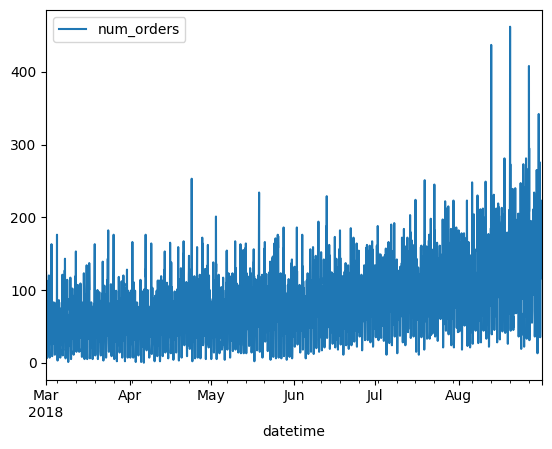

In [11]:
#построим график:
data.plot()

### Выводы:

    1. В исходных данных предоставлены 26496 строки о заказах такси в аэропортах (с 1 марта 2018 по 31 августа 2018 года).
    2. Произведено ресемплирование данных по одному часу.
    3. Произведена проверка, что данные предоставлены по возрастанию.

## 2. Исследовательский анализ данных

In [12]:
#определим тренды и сезонность:
decomposed = seasonal_decompose(data)

<AxesSubplot:xlabel='datetime'>

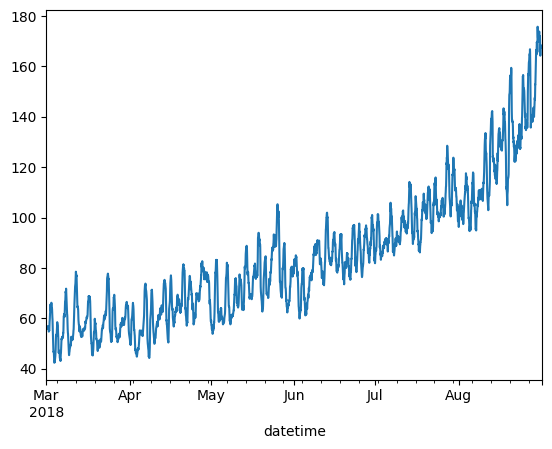

In [13]:
#построим график тренда:
decomposed.trend.plot()

Из графика заметен общий тренд на увеличение количества заказов.

<AxesSubplot:xlabel='datetime'>

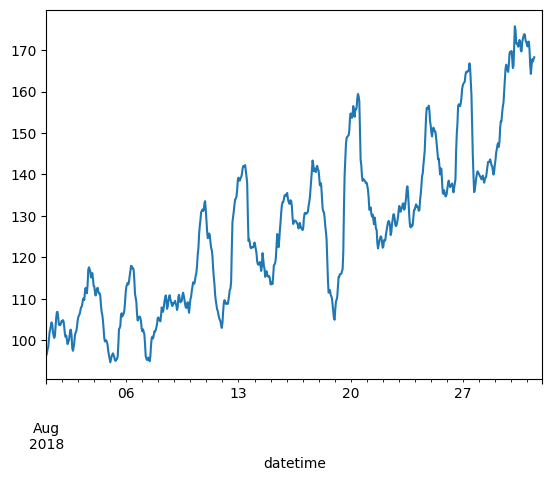

In [14]:
#построим график тренда для 1 месяца:
decomposed.trend['2018-08-01':'2018-08-31'].plot()

Из графика видно, что количество заказов зависит от дня недели.

<AxesSubplot:xlabel='datetime'>

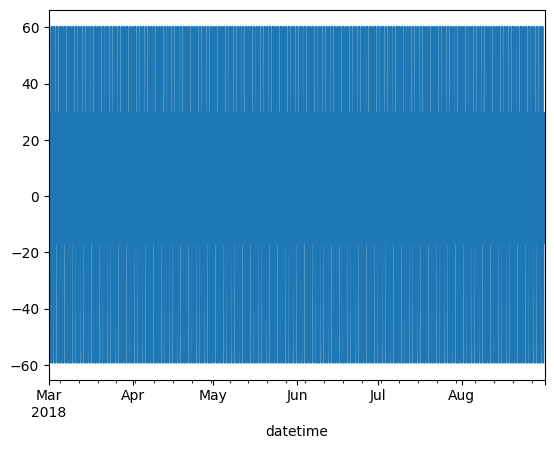

In [15]:
# построим график сезонности:
decomposed.seasonal.plot()

Из общего графика ничего непонятно. Возьмем для рассмотрения неделю:

<AxesSubplot:xlabel='datetime'>

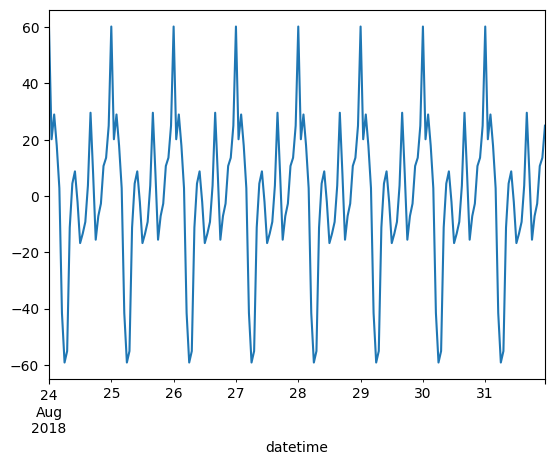

In [16]:
# построим график сезонности за неделю:
decomposed.seasonal['2018-08-24':'2018-08-31'].plot()

Из графика видно, что сезонность определяется 24 часами.

<AxesSubplot:xlabel='datetime'>

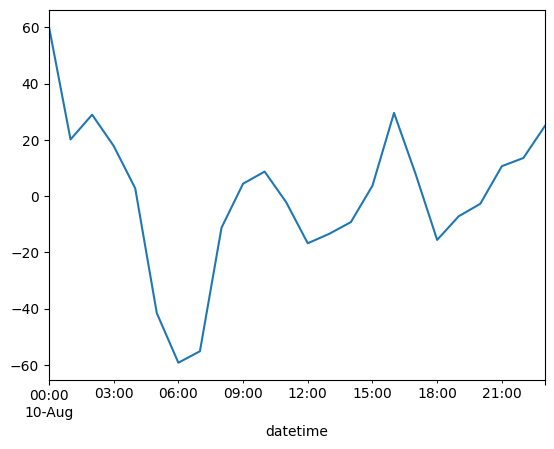

In [17]:
# построим график сезонности за 1 день:
decomposed.seasonal['2018-08-10 00:00:00':'2018-08-10 23:00:00'].plot()

Из графика видно, что в течение дня также присутствуют колебания количество заказов в зависимости от того, который час.
В признаки добавим следующие столбцы: день недели и час (из графика сезонности), отстающие значения в течение 12 часов (из сезонности напрашивается 24 часа, но читала в статье на хабре, что лучше больше 12 измерений не брать), и скользящее среднее по 24 часам для отображения тренда общего роста числа заказов.
Не стала добавлять в признаки месяц, так как в данных представлены только полгода, категориальная переменная, для которой есть в выборке только половина значений, мне кажется, не нужна. Так же не добавила в признак день, потому что сильного влиния дня на графиках не увидела.

In [26]:
# функция для создания признаков:
def make_features (data, max_log, rolling_mean_size):
    # создание датафрейма для хранения признаков:
    features = pd.DataFrame(index=data.index)
    # добавим в признаки столбцы с календарными признаками:
    features['dayofweek'] = data.index.dayofweek
    features['hour'] = data.index.hour
    # добавим в признаки отстающие значения:
    for lag in range(1, max_log+1):
        features['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    # добавим в признаки скользящее среднее:
    features['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    # исключим строки с пропусками:
    features = features.dropna()
    return features

In [30]:
# выделим признаки и целевой признак:
features = make_features (data, 12, 24)
target = data.loc[features.index, 'num_orders']

In [31]:
# разделим данные на обучающую и тестовую выборки:
features_train, features_test, target_train, target_test = train_test_split(features, target, shuffle=False, test_size=0.1)

In [32]:
# определим категориальные признаки:
cat_features = ['dayofweek', 'hour']

### Выводы:

    1. Определили общий тренд на увеличение количества заказов такси.
    2. Определили сезонность: день (24 часа).
    3. Для отображения сезонности добавили в признаки календарные признаки, а именно день недели и час, а также отстающие значения в течение 12 часов.
    4. Для отображения общего тренда добавили в признаки скользящее среднее по 24 часам.
    5. Исключили данные с пропусками, появившимися в результате получения отстающих значений.
    6. Разделили данные на обучающую и тестовую выборку.
    7. Определили категориальные признаки.

## 3. Обучение моделей

In [33]:
# создадим функцию для вычисления метрики rmse
def rmse(target, predicted):
    error = (target-predicted)**2
    return np.sqrt(np.mean(error))
rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [34]:
# параметр для кросс-валидации временных рядов
tscv = TimeSeriesSplit(n_splits=3)

Модель линейной регрессии:

In [35]:
# кодирование категориальных признаков:
enc_ohe = OneHotEncoder(sparse=False, drop='first')
enc_ohe.fit(features_train[cat_features])
features_train_ohe = pd.DataFrame(enc_ohe.transform(features_train[cat_features]),  \
                                     columns=enc_ohe.get_feature_names(features_train[cat_features].columns), \
                                     index=features_train.index)

In [36]:
# подготовка признаков для линейной регрессии:
features_train_linear = features_train.drop(cat_features, axis=1)
features_train_linear = pd.concat([features_train_linear, features_train_ohe], axis=1)

In [37]:
# обучение линейной регрессии:
model_linear = LinearRegression()
rmse_linear_cv = cross_val_score(model_linear, features_train_linear, target_train, cv=tscv, scoring=rmse_scorer)
rmse_linear = rmse_linear_cv.mean()

Модель случайного леса:

In [38]:
# настройка гиперпараметров для модели случайного леса:
#варианты гиперпараметров
params = {'n_estimators': [50, 75, 100, 150],
         'max_depth': [15, 20, 25, 30]} 
#подбор гиперпараметров
model_forest = RandomizedSearchCV(RandomForestRegressor(random_state=12345), params, scoring=rmse_scorer, cv=tscv) #подбор гиперпараметров
model_forest.fit(features_train, target_train)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                   estimator=RandomForestRegressor(random_state=12345),
                   param_distributions={'max_depth': [15, 20, 25, 30],
                                        'n_estimators': [50, 75, 100, 150]},
                   scoring=make_scorer(rmse, greater_is_better=False))

Модель LGBMRegressor:

In [39]:
# настройка гиперпараметров для модели LGBMRegressor
#варианты гиперпараметров
params = {'max_depth': [15, 20, 25, 30],
          'learning_rate': [0.01, 0.05, 0.1, 0.15]}
#подбор гиперпараметров
model_lgbm = RandomizedSearchCV(LGBMRegressor(random_state=12345, objective='rmse'), \
                                params, scoring=rmse_scorer, cv=tscv) #подбор гиперпараметров
model_lgbm.fit(features_train, target_train, categorical_feature=cat_features)

D:\Anaconda\envs\ds_practicum_env\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
D:\Anaconda\envs\ds_practicum_env\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
D:\Anaconda\envs\ds_practicum_env\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
D:\Anaconda\envs\ds_practicum_env\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
D:\Anaconda\envs\ds_practicum_env\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
D:\Anaconda\envs\ds_practicum_env\lib\site-packages\lightgbm\basic.py:2065: UserWarni

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                   estimator=LGBMRegressor(objective='rmse',
                                           random_state=12345),
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1,
                                                          0.15],
                                        'max_depth': [15, 20, 25, 30]},
                   scoring=make_scorer(rmse, greater_is_better=False))

Модель CatBoostRegressor: 

In [40]:
# настройка гиперпараметров для модели CatBoostRegressor
#варианты гиперпараметров
params = {'max_depth': [5, 10, 15],
          'learning_rate': [0.05, 0.1, 0.15]}
#подбор гиперпараметров
model_ctb = RandomizedSearchCV(CatBoostRegressor(loss_function='RMSE', iterations=500), \
                               params, scoring=rmse_scorer, cv=tscv) #подбор гиперпараметров
model_ctb.fit(features_train, target_train, cat_features=cat_features,verbose=100)

D:\Anaconda\envs\ds_practicum_env\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0:	learn: 28.7378137	total: 214ms	remaining: 1m 46s
100:	learn: 16.7341537	total: 1.61s	remaining: 6.37s
200:	learn: 15.0192717	total: 2.88s	remaining: 4.29s
300:	learn: 13.7110845	total: 4.22s	remaining: 2.79s
400:	learn: 12.5345602	total: 5.55s	remaining: 1.37s
499:	learn: 11.5184371	total: 7.03s	remaining: 0us
0:	learn: 31.3270604	total: 13.1ms	remaining: 6.55s
100:	learn: 19.0118193	total: 1.6s	remaining: 6.31s
200:	learn: 17.5899430	total: 2.96s	remaining: 4.4s
300:	learn: 16.5588578	total: 4.32s	remaining: 2.86s
400:	learn: 15.5936781	total: 5.7s	remaining: 1.41s
499:	learn: 14.7202121	total: 7.05s	remaining: 0us
0:	learn: 33.1933332	total: 12.7ms	remaining: 6.33s
100:	learn: 20.4761924	total: 1.45s	remaining: 5.74s
200:	learn: 19.3477832	total: 2.86s	remaining: 4.25s
300:	learn: 18.3291126	total: 4.57s	remaining: 3.02s
400:	learn: 17.5703956	total: 6.08s	remaining: 1.5s
499:	learn: 16.9182224	total: 7.65s	remaining: 0us
0:	learn: 28.6523649	total: 58.4ms	remaining: 29.1s
100:	le

200:	learn: 0.9978908	total: 4m 12s	remaining: 6m 15s
300:	learn: 0.3250850	total: 6m 18s	remaining: 4m 10s
400:	learn: 0.1280221	total: 8m 21s	remaining: 2m 3s
499:	learn: 0.0525593	total: 10m 29s	remaining: 0us
0:	learn: 37.8227929	total: 14.9ms	remaining: 7.46s
100:	learn: 22.7177221	total: 1.63s	remaining: 6.44s
200:	learn: 21.5437432	total: 3.23s	remaining: 4.8s
300:	learn: 20.5544995	total: 4.86s	remaining: 3.21s
400:	learn: 19.7704266	total: 6.5s	remaining: 1.6s
499:	learn: 19.1461677	total: 8.37s	remaining: 0us


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                   estimator=<catboost.core.CatBoostRegressor object at 0x0000020EB1312940>,
                   param_distributions={'learning_rate': [0.05, 0.1, 0.15],
                                        'max_depth': [5, 10, 15]},
                   scoring=make_scorer(rmse, greater_is_better=False))

In [41]:
# создадим таблицу для сравнения работы моделей:
criteria = pd.DataFrame(0, columns=['RMSE'], \
                        index=['LinearRegression', 'RandomForestRegressor', 'LGBMRegressor', 'CatBoostRegressor'])

In [42]:
# заполним столбец с указанием rmse:
criteria.loc['LinearRegression', 'RMSE'] = abs(round(rmse_linear, 3))
criteria.loc['RandomForestRegressor', 'RMSE'] = abs(round(model_forest.best_score_, 3))
criteria.loc['LGBMRegressor', 'RMSE'] = abs(round(model_lgbm.best_score_, 3))
criteria.loc['CatBoostRegressor', 'RMSE'] = abs(round(model_ctb.best_score_, 3))

In [43]:
criteria

,RMSE
LinearRegression,26.618
RandomForestRegressor,26.728
LGBMRegressor,26.522
CatBoostRegressor,26.601


### Выводы:

    1. Создана функция для вычисления RMSE
	2. Обучена модель линейной регрессии.
	3. Подобраны гиперпараметры модели случайного леса.
	4. Подобраны гиперпараметры модели LGBMRegressor.
    5. Подобраны гиперпараметры модели CatBoostRegressor.
    6. Лучшее значение RMSE=26,522 у модели LGBMRegressor.

## 4. Тестирование модели

In [46]:
# вычисление rmse тестовой выборки
predicted_test_lgbm = model_lgbm.predict(features_test)
rmse(target_test, predicted_test_lgbm)

40.33977147188413

In [51]:
predicted_test = pd.Series(predicted_test_lgbm, index=target_test.index)

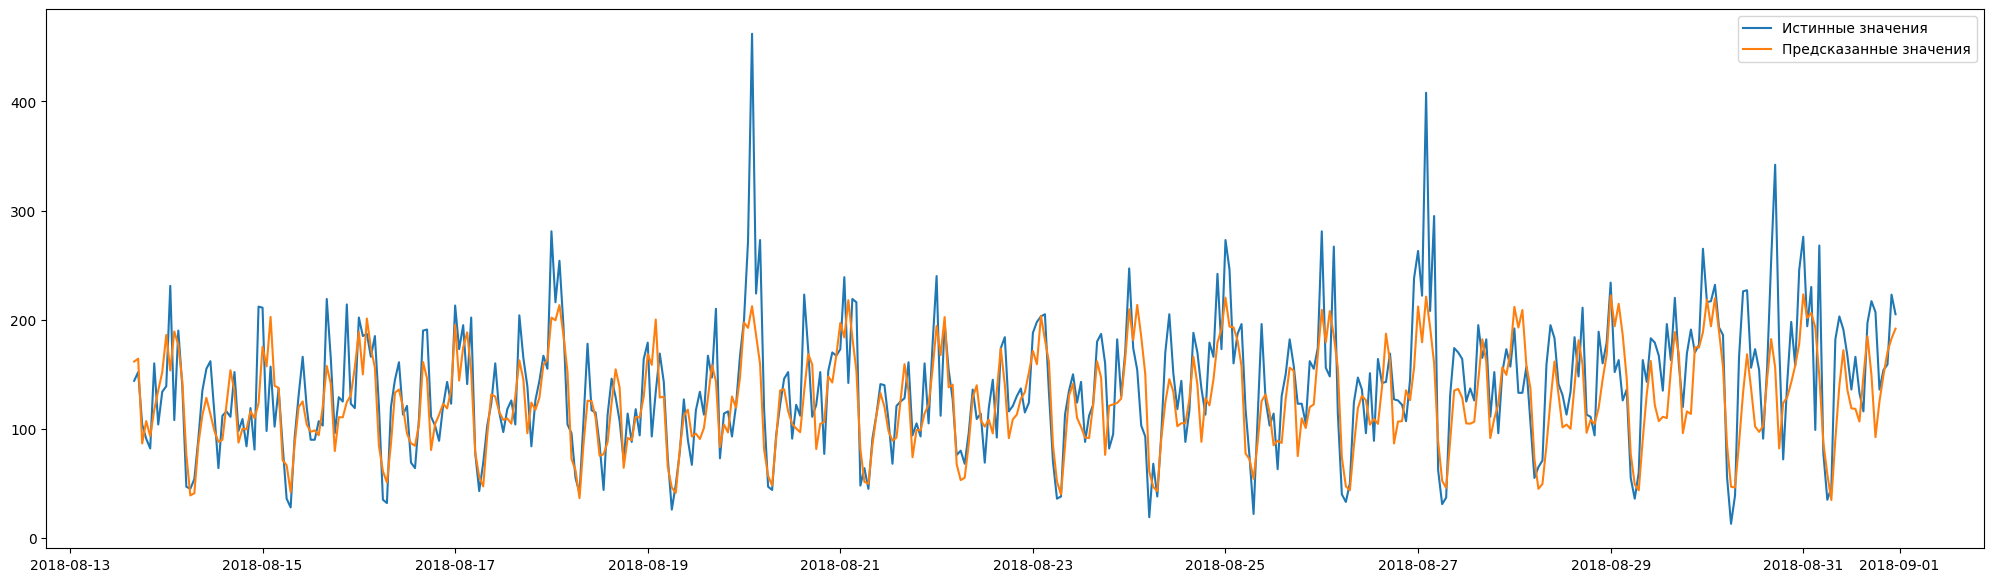

<Figure size 5000x1000 with 0 Axes>

In [98]:
# отобразим на графике таргеты тестовой выборки и предсказанные лучшей моделью значения:
fig, ax = plt.subplots(figsize=(25, 7))
ax.plot(target_test, label = "Истинные значения")
ax.plot(predicted_test, label = "Предсказанные значения")
plt.figure(figsize=(50,10))
ax.legend()
plt.show()

## 5. Выводы

    1. В ходе подготовки данных:
        - в исходных данных предоставлены 26496 данных о заказах такси в аэропортах (с 1 марта 2018 по 31 августа 2018 года);
        - произведено ресемплирование данных по одному часу.
    2. В ходе анализа данных:
        - для отображения сезонности добавили в признаки календарные признаки, а именно день недели и час, а также отстающие значения в течение 12 часов;
        - для отображения общего тренда роста количества заказов такси добавили в признаки скользящее среднее по 24 часам;
        - разделили данные на обучающую и тестовую выборку.
    3. Обучены и подобраны гиперпараметры для линейной регрессии, случайного леса, LGBMRegressor и CatBoostRegressor.
    4. Лучшее значение метрики RMSE=26,616 у модели LGBMRegressor.
    5. Значение метрики RMSE лучшей модели на тестовой выборке = 40.339.